In [37]:
import pyedflib
import mylib
import mvar
import mygraph
import numpy as np
import pandas as pd
from igraph import Graph
import re
import igraph

In [38]:
case_open = "./data/S001R01.edf"
case_closed = "./data/S001R02.edf"

#### 1.1

Estimate functional brain connectivity among 64 channels using one of the MVAR estimators: 

- Partial Directed Coherence (PDC), 
- Direct Transfer Function (DTF). 

Select **one relevant frequency value**. 

Apply a **threshold** so that the resulting binary connectivity matrices have network density equal to 20%. 

Create a graphical representation of the binary adjacency matrix.

In [39]:
#%%
# 1.1 - 1.2

def receive_data(path, freq = 10, threshold = 0.1, DTF = True):
    """
    This function builds a brain network given in input:
    - path of the EDF file
    - freq: the frequency we want to conduct analysis on
    - threshold: a threshold on the graph's density
    - DFT: boolean: if True estimates the Direct Tranfer Function (DFT)
                    if False estimates the Partial Directed Coherence (PDC)
    """
    #%% Load data and store into a dataframe
    
    print("Loading data from", path, "...")
    f = pyedflib.EdfReader(path)
    print("...done")

    data = mylib.edfToDataFrame(f)
    f._close()
    T = 1./f.getSampleFrequencies()[1]
    measures = data.T.values
    N, n = measures.shape
    p = 3
    A_est, sigma = mvar.mvar_fit(measures, p)
    sigma = np.diag(sigma)  # The noise for each time series
    if DTF:
        # compute DTF
        print("Computing DFT...")
        Adj, freqs = mvar.DTF(A_est, sigma, T)
        print("... done")
    else:
        # compute PDC
        print("Computing PDC")
        Adj, freqs = mvar.PDC(A_est, sigma, T)
        print("... done")
        
    # take take a graph relative to a specific frequency expressed in Hz
    print("Building network to analyse interactions at", freq, "Hz")
    # select the correspondent weights
    Adj = Adj[np.where(freqs == mylib.find_nearest(freqs, freq)),:,:].reshape(64, 64)
    G = Graph.Weighted_Adjacency(Adj.tolist(), mode = 0) # mode=0 is for directed / mode=1 is for indirected graph

    # get channel names, cleaning replacing any dot with a void charachter
    G.vs["label"] = list(map(lambda x: re.sub('\.', '', x), data.columns.values))
    G = mygraph.add_brain_layout(G)

    print("Applying a threshold on network density of", round(threshold*100), "% ...")
    G = mygraph.applyTreshold(G, threshold)
    print("... done")
    
    return G

In [40]:
#%% 1.1
Gd = receive_data(path = case_open, freq = 10, threshold=0.2, DTF = True)

Loading data from ./data/S001R01.edf ...
...done
Computing DFT...
... done
Building network to analyse interactions at 10 Hz
Applying a threshold on network density of 20 % ...
... done


#### 1.2 

Perform task 1.1 using both estimators (PDC and DTF).

In [42]:
#%% 1.2
Gp = receive_data(path = case_open, freq = 10, threshold=0.2, DTF = False)

Loading data from ./data/S001R01.edf ...
...done
Computing PDC
... done
Building network to analyse interactions at 10 Hz
Applying a threshold on network density of 20 % ...
... done


#### 1.3 

Perform task 1.1 using thresholds yielding the following density values: 1%, 5%, 10%, 20%, 30%, 50%.

In [ ]:
#%% 1.3
densities = [0.05, 0.1, 0.2, 0.3, 0.5]
densities = densities[::-1]
graphs_over_densities = []
for density in densities:
    graphs_over_densities.append(build_graph(D, freqsD, 10, density))
graphs_over_densities

#### 1.5

Make a topographical representation of the networks.

Making a topological representation


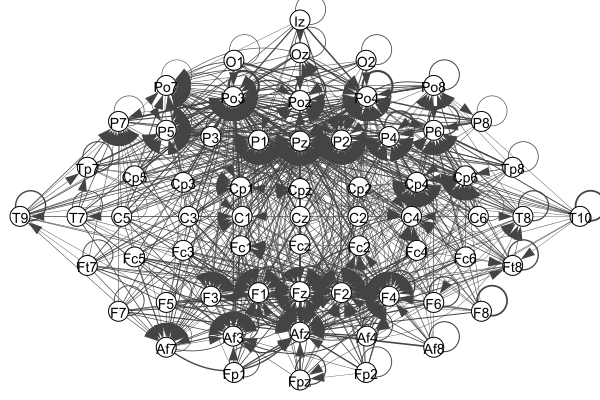

In [43]:
#%% 1.5
print("Making a topological representation")

visual_style = {}
visual_style["vertex_size"] = 20
visual_style["vertex_color"] = "white"
visual_style["vertex_label"] = Gd.vs["label"]
visual_style["edge_width"] = [3* weight for weight in Gd.es["weight"]]
visual_style["layout"] = Gd.vs["coordinates"]

igraph.plot(Gd,  bbox=(0, 0, 600, 400), **visual_style)

#### 1.6 

Perform task 1.1 considering a **second frequency value** belonging to a **different EEG rhythm** with respect to the first choice.

In [46]:
#%% 1.6
Gd = receive_data(case_open, freq = 28, threshold = 0.1, DTF = True)

Loading data from ./data/S001R01.edf ...
...done
Computing DFT...
... done
Building network to analyse interactions at 28 Hz
Applying a threshold on network density of 10 % ...
... done


#### 2.1

Compute 

- binary global (clustering coefficient, path length) graph indices
- local (degree,in/out-degree) graph indices. 

List the highest 10 channels for local indices

In [47]:
#%% 2.1
print("Macroscopic Network Analysis")
# global clustering coefficient
# https://igraph.org/python/doc/igraph.Graph-class.html#transitivity_avglocal_undirected
print("global clustering coefficient = ", round(Gd.transitivity_undirected(), 3))

# average path length
# https://igraph.org/python/doc/igraph.GraphBase-class.html#average_path_length
print("global average path lenght = ", round(Gd.average_path_length(directed = True), 3))

Macroscopic Network Analysis
global clustering coefficient =  0.292
global average path lenght =  1.899


In [48]:
print("Microscopic Network Analysis")
local_ind = pd.DataFrame.from_dict(      {
                "channel" : Gd.vs["label"] ,
                "degree" : Gd.strength(mode = 3),
                "out-degree" : Gd.strength(mode = 1),
                "in-degree" : Gd.strength(mode = 2)
                }
        )

local_ind.set_index("channel", inplace = True)
print("Top 10 channels by degree\n", local_ind.sort_values(by = "degree", ascending = False)[1:10]["degree"])
print("Top 10 channels by OUT degree\n", local_ind.sort_values(by = "out-degree", ascending = False)[1:10]["out-degree"])
print("Top 10 channels by IN degree\n", local_ind.sort_values(by = "in-degree", ascending = False)[1:10]["in-degree"])



# 2.7
local_ind = pd.DataFrame.from_dict(      {
                "channel" : Gd.vs["label"] ,
                "strength" : Gd.strength(mode = 3,  weights = "weight"),
                "out-strength" : Gd.strength(mode = 1,  weights = "weight"),
                "in-strength" : Gd.strength(mode = 2,  weights = "weight")
                }
        )

local_ind.set_index("channel", inplace = True)
print("Top 10 channels by generalized degree\n", local_ind.sort_values(by = "strength", ascending = False)[1:10]["strength"])
print("Top 10 channels by generalized OUT degree\n", local_ind.sort_values(by = "out-strength", ascending = False)[1:10]["out-strength"])
print("Top 10 channels by generalized IN degree\n", local_ind.sort_values(by = "in-strength", ascending = False)[1:10]["in-strength"])

Microscopic Network Analysis
Top 10 channels by degree
 channel
P2     47.0
Pz     42.0
F4     35.0
Afz    34.0
P4     30.0
F1     21.0
P6     20.0
F2     20.0
P1     19.0
Name: degree, dtype: float64
Top 10 channels by OUT degree
 channel
Fc6    10.0
P1      9.0
Af4     9.0
C2      8.0
F3      8.0
Ft7     8.0
Fp1     8.0
Tp7     8.0
Cp1     8.0
Name: out-degree, dtype: float64
Top 10 channels by IN degree
 channel
P2     40.0
Pz     35.0
F4     28.0
Afz    28.0
P4     24.0
Po4    16.0
F1     15.0
P6     15.0
F2     14.0
Name: in-degree, dtype: float64
Top 10 channels by generalized degree
 channel
Pz     13.405068
P2     11.962448
Afz    11.024742
F4     10.531245
P4      9.869480
P6      7.212995
Po4     7.071323
F1      6.488820
F2      5.692664
Name: strength, dtype: float64
Top 10 channels by generalized OUT degree
 channel
Fc6    2.519001
P1     2.508593
Af4    2.426968
Fp1    2.349191
Fz     2.319730
F3     2.315411
Fc2    2.289956
Fcz    2.265189
Cp1    2.264383
Name: out-stren

#### 2.2

Search in the literature a definition of **small-worldness index** and compute it.

In [14]:
#%% 2.2 # to be fixed !!
import bct

print("Calculating Small World Index...")

Actual = np.array(Gd.get_adjacency(attribute = "weight").data)
Lattice, a, b, iter2 = bct.latmio_dir(Actual, 10, D = None)
#Random, iter1 = bct.randmio_dir(Actual, 20)


# Bootstrap
B = 10
Lr = list()
Cr = list()
for i in range(B):
    Random, iter1 = bct.randmio_dir(Actual, 10)
    #print(Random[0,1])
    Lr.append(Graph.Weighted_Adjacency(Random.tolist(), mode = 0).average_path_length(directed = True))
    Cr.append(Graph.Weighted_Adjacency(Random.tolist(), mode = 0).transitivity_undirected(mode="nan"))
    #print(i, Lr, Cr)
    
Lr_mean = sum(Lr)/float(len(Lr))
Cr_mean = sum(Cr)/float(len(Cr))


L = Graph.Weighted_Adjacency(Actual.tolist(), mode = 0).average_path_length(directed = True)
Ll = Graph.Weighted_Adjacency(Lattice.tolist(), mode = 0).average_path_length(directed = True)
#Lr = Graph.Weighted_Adjacency(Random.tolist(), mode = 0).average_path_length(directed = True)

C = Graph.Weighted_Adjacency(Actual.tolist(), mode = 0).transitivity_undirected(mode="nan")
Cl = Graph.Weighted_Adjacency(Lattice.tolist(), mode = 0).transitivity_undirected(mode="nan")
#Cr = Graph.Weighted_Adjacency(Random.tolist(), mode = 0).transitivity_undirected(mode="nan")

SWI = mylib.swi(L, Ll, Lr_mean, C, Cl, Cr_mean)
#[mylib.swi(L, Ll, Lr, C, Cl, Cr) for Lr, Cr in ]
print("SWI =", SWI)

Calculating Small World Index...
SWI = 6.3935129388106855


#### 2.4

Study the behaviour of global graph indices in function of network density (see point 2.3 for density values).

Studying the behaviour of global graph indices in function of network density...
Ploting the result of the analysis


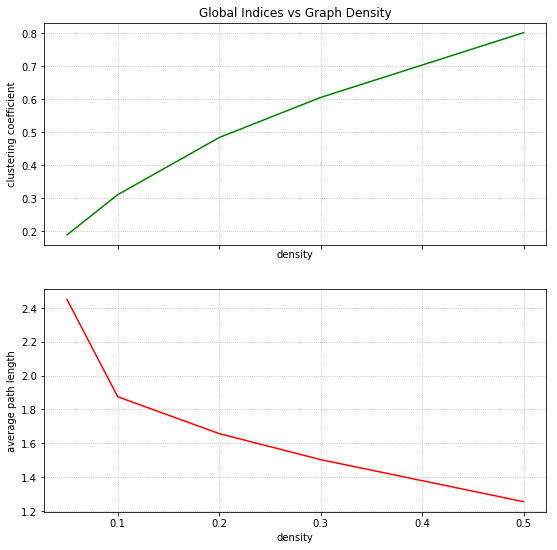

In [25]:
#%% 2.4 Study the behaviour of global graph indices in function of network density
print("Studying the behaviour of global graph indices in function of network density...")
densities = [0.05, 0.1, 0.2, 0.3, 0.5] # edit these with the ones provided by the prof

clustering_coeffs = []
average_path_lengths =  []
# there is a specific reason why we start from higher densities and then we
# decrease it: the function applyThreshold takes a graph and simply picks less 
# important edges (to which correspond low weights) erasing them from the network:
# to do that it has to find the minimum above N* x N* weights. 
# This is quite computationally expensive in our simple implementation:
# to speed up a bit our analysis we put the function in the condition of having
# at each step a smaller amount N*, avoiding to replicate the same minimizations
# multiple times
D, freqs = mvar.DTF(A_est, sigma, T)
freq = 10
D = D[np.where(freqs == mylib.find_nearest(freqs, freq)),:,:].reshape(64, 64)
Gd = Graph.Weighted_Adjacency(D.tolist(), mode = 0)
for density in densities[::-1]:
    Gd = mygraph.applyTreshold(Gd, density)
    clustering_coeffs.append(Gd.transitivity_undirected())
    average_path_lengths.append(Gd.average_path_length(directed = False, unconn=True))
print("Ploting the result of the analysis")
mylib.plot_analysis(densities, clustering_coeffs, average_path_lengths)

#### 2.5 

Make a Topographical representation of local indices

Topographical representation of weighted degree


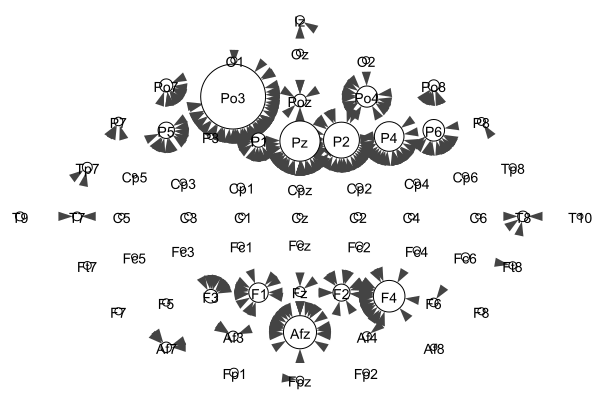

In [49]:
#%% 2.5 Make a Topographical representation of local indices
import matplotlib.pyplot as plt
Gd.vs["strength"] = Gd.strength(mode = 3, weights = "weight")
Gd.vs["in-strenght"] = Gd.strength(mode = 2, weights = "weight")
Gd.vs["out-strength"] = Gd.strength(mode = 1, weights = "weight")

visual_style["vertex_size"] = [3* strength for strength in Gd.vs["strength"]]
visual_style["edge_width"] = 0

print("Topographical representation of weighted degree")
igraph.plot(Gd, bbox=(0, 0, 600, 400), **visual_style)

Topographical representation of weighted in-degree


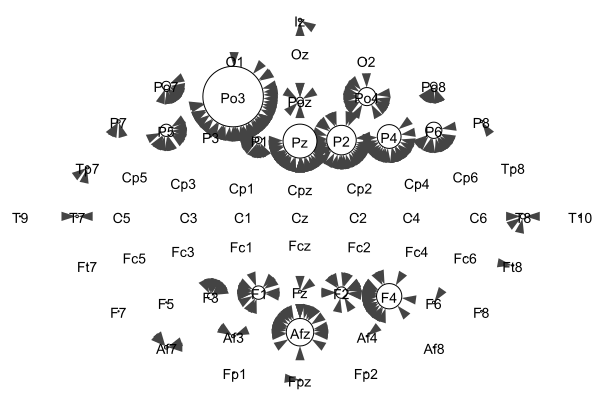

In [50]:
visual_style["vertex_size"] = [3* strength for strength in Gd.vs["in-strenght"]]
visual_style["edge_width"] = 0
print("Topographical representation of weighted in-degree")
igraph.plot(Gd , bbox=(0, 0, 600, 400),**visual_style)

Topographical representation of weighted out-degree


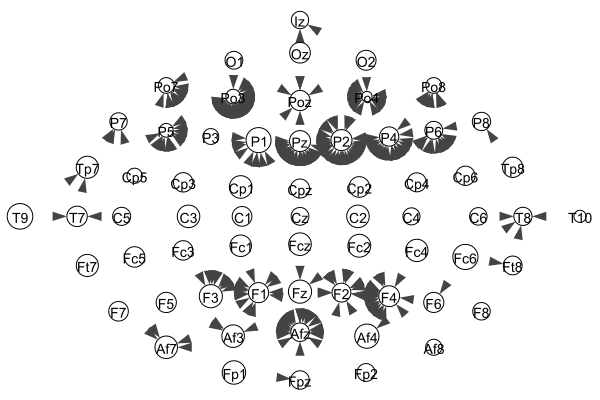

In [51]:
visual_style["vertex_size"] = [10* strength for strength in Gd.vs["out-strength"]]
visual_style["edge_width"] = 0
print("Topographical representation of weighted out-degree")
igraph.plot(Gd, bbox=(0, 0, 600, 400), **visual_style)

In [52]:
#%% 3 Motif analysis

path = './data/inputForMA.txt'
print("Writing input file for Motif Analysis to", path, "...")
mylib.write_inputFileForMotifAnalysis(Gd, file = path)
print("\n.. done")

Writing input file for Motif Analysis to ./data/inputForMA.txt ...

.. done


In [16]:
#%% 4.1 Community detection


def louvain(G):
    import louvain
    louvain.set_rng_seed(123452)
    G.vs['degree'] = G.degree()
    #G = np.matrix(G.get_adjacency(attribute='weight').data)
    #G = pos_Igraph(G,do_plot=False)
    partition = louvain.find_partition(G, louvain.ModularityVertexPartition,weights=G.es['weight'])
    
    return(partition, G)

In [4]:
G_open = receive_data(path = case_open, freq = 10, threshold=0.1, DTF = True)

G_closed = receive_data(path = case_closed, freq = 10, threshold=0.1, DTF = True)

Loading data from ./data/S001R01.edf ...
...done
Computing DFT...
... done
Building network to analyse interactions at 10 Hz
Applying a threshold on network density of 10 % ...
... done
Loading data from ./data/S001R02.edf ...
...done
Computing DFT...
... done
Building network to analyse interactions at 10 Hz
Applying a threshold on network density of 10 % ...
... done


In [14]:
part_open,G_open = louvain(G_open)
print("The estimated number of communities for eyes-open case is",len(set(part_open.membership)))
print('\n')
print("Communities")
for n in range(0,len(part_open)):
    print('Community number', n, '- size:', len(part_open[n]))
    
#Create a dictionary whith keys as channels (names of our nodes) and values the community they belong
print("Case: eyes-open")
comm_detect = dict(zip(G_open.vs['label'], part_open.membership))
print("A dictionary whith keys as channels (names of our nodes) and values the community they belong:")
print('\n')
new_dict = {}
for pair in comm_detect.items():
    if pair[1] not in new_dict.keys():
        new_dict[pair[1]] = []

    new_dict[pair[1]].append(pair[0])

print(dict(sorted(new_dict.items())))

The estimated number of communities for eyes-open case is 4


Communities
Community number 0 - size: 31
Community number 1 - size: 21
Community number 2 - size: 11
Community number 3 - size: 1


In [19]:
part_closed,G_closed = louvain(G_closed)
print("The estimated number of communities for eyes-closed case is",len(set(part_closed.membership)))
print('\n')
print("Communities")
for n in range(0,len(part_closed)):
    print('Community number', n, '- size:', len(part_closed[n]))

    #Create a dictionary whith keys as channels (names of our nodes) and values the community they belong
print("Case: eyes-closed")
comm_detect = dict(zip(G_closed.vs['label'], part_closed.membership))
print("A dictionary whith keys as channels (names of our nodes) and values the community they belong:")
print('\n')
new_dict = {}
for pair in comm_detect.items():
    if pair[1] not in new_dict.keys():
        new_dict[pair[1]] = []

    new_dict[pair[1]].append(pair[0])

print(dict(sorted(new_dict.items())))

The estimated number of communities for eyes-closed case is 4


Communities
Community number 0 - size: 26
Community number 1 - size: 22
Community number 2 - size: 14
Community number 3 - size: 2


At rest in eyes-open conditions


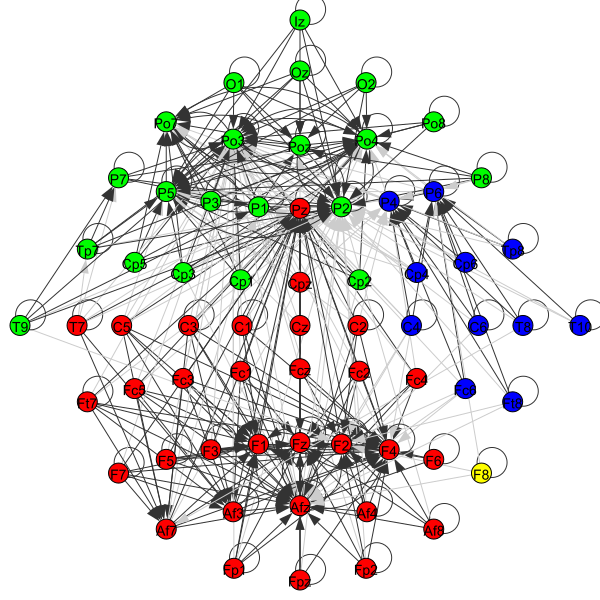

In [27]:
#%% 4.2 Graphical Representation of the Community Structure 
print("At rest in eyes-open conditions")
igraph.plot(part_open, layout=G_open.vs["coordinates"], vertex_label=G_open.vs["label"])

At rest in eyes-closed conditions


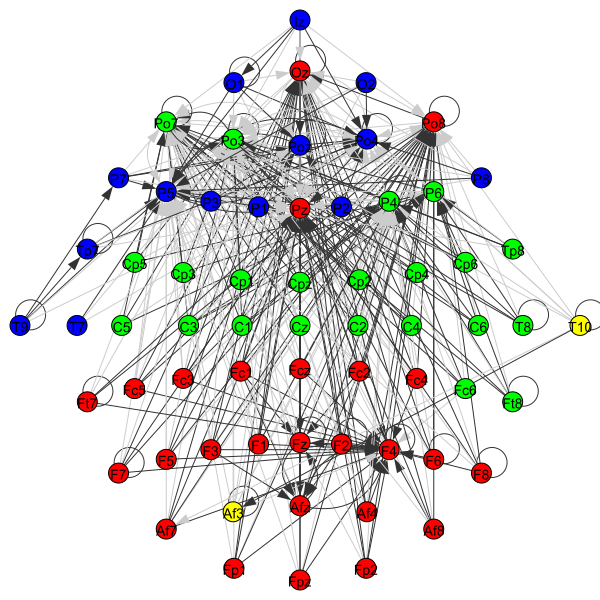

In [29]:
print("At rest in eyes-closed conditions")
igraph.plot(part_closed,layout=G_closed.vs["coordinates"],vertex_label=G_closed.vs["label"])

In [34]:
#%% 4.3 Modularity-based vs Information Theory-based approaches

The estimated number of communities for eyes-open case is 2
The estimated number of communities for eyes-closed case is 1
Graph for both cases


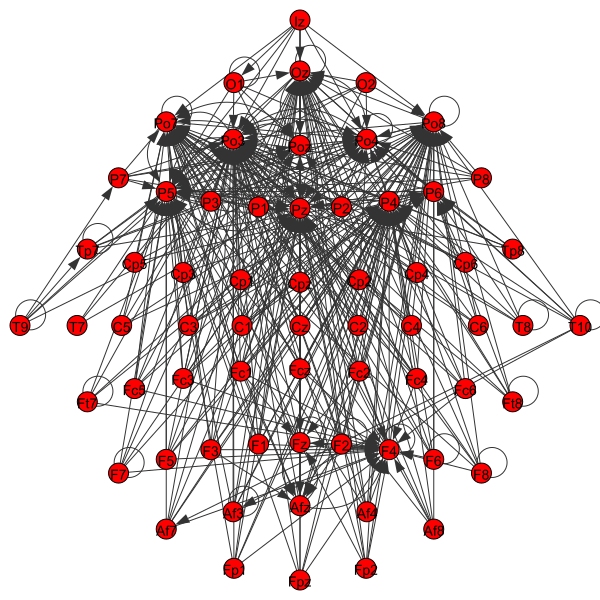

In [33]:
##Case OPEN

weights = G_open.es['weight']
comms = G_open.community_infomap(edge_weights = weights,trials = 50)
membership = comms.membership
print("The estimated number of communities for eyes-open case is",len(comms))

##Case CLOSED

weights = G_closed.es['weight']
comms = G_closed.community_infomap(edge_weights = weights,trials = 50)
membership = comms.membership
print("The estimated number of communities for eyes-closed case is",len(comms))

print("Graph for both cases")
igraph.plot(comms,layout=G_open.vs["coordinates"],vertex_label=G_open.vs["label"])
#igraph.plot(comms,layout=G_closed.vs["coordinates"],vertex_label=G_closed.vs["label"])

Infomap always finds a single community containing all nodes of the network. However, a modularity-based methods, such as the Louvain method,finds a few communities (always more than one for both rest cases) for the specific average degree of our network. 

These results show that given the specified density of our network that we used the louvain algorithm (modularity based approach) tends to find a few small communities while the infomap method (information theory approach) it detects a single community in the same network with these specific dense connections.